# Exploring dataset using Time Series Analysis
**About the data** - The data was published as part of a Kaggle competition [here](https://www.kaggle.com/c/competitive-data-science-predict-future-sales). This data includes daily historical sales data. 

**Aim** - The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

**Reference** - Some of the analysis here is inpored by [this notebook](https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts/notebook).  

### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import random as rd 
import datetime 

import matplotlib.pyplot as plt 
import seaborn as sns 



from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

### Exploring the data

In [2]:
# loading the training data
data=pd.read_csv("data/sales_train.csv")
# correcting the datatime format
data.date=data.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [4]:
data.head(5)
# date - date in format dd/mm/yyyy
# date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
# shop_id - unique identifier of a shop
# item_id - unique identifier of a product
# item_price - current price of an item
# item_cnt_day - number of products sold. You are predicting a monthly amount of this measure


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


### Univariate Analysis

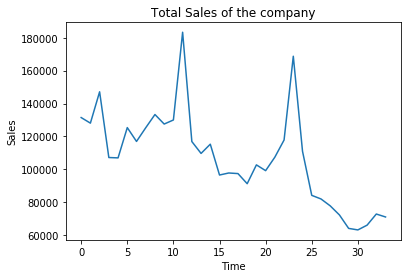

In [5]:
ts=data.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

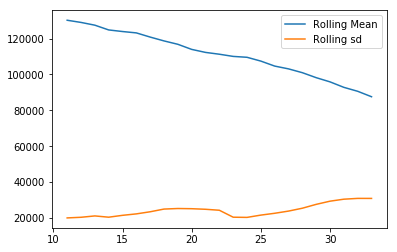

In [6]:
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()
plt.show()

**Observation** - From the single graph and rolling window analysis of mean and standard deviation, we see that the average value has decreasing, linear trend.

**Next Steps** - Since we see that there might be some kind of trend, let us further decompose this series into systematic (level, trend, seasonal) and non-systematic (noise) trends. [Read more here](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

### Time Series Decomposition
**Time-Series Components** - We can assume that the above-mentioned components can either be:
1. Additive - Level + Trend + Seasonality + Noise
2. Multiplicative - Level * Trend * Seasonality * Noise
For now it seems like the trends are linear so lets explore it further.

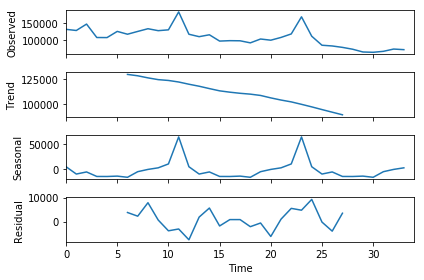

In [7]:
result = sm.tsa.seasonal_decompose(ts.values,freq=12,
                                   model='additive')
result.plot()
plt.show()

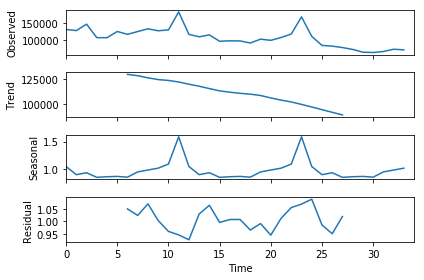

In [8]:
result = sm.tsa.seasonal_decompose(ts.values,freq=12,
                                   model='multiplicative')
result.plot()
plt.show()

**Observation** - For this dataset, seems like both additve and multiplicative assumptions can extract the trend and seasonality quite well. Moreover, since there is a clear trend, this plot os not stationary. This was also evident in the rolling mean and variance plots.

### Stationary Tests
While we have a fair idea that the series might not be stationary, we can do some formal tests to confirm:
1. Augmented Dicky-Fuller Test - a unit root test that determines how strongly the series follows a root

In [9]:
result = adfuller(ts.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.395704
p-value: 0.142953
Critical Values:
	5%: -2.954
	1%: -3.646
	10%: -2.616


**Observation** - We accept the null hypothesis that there is trend line.

### Removing trend from data
There are two ways to remove trend:
1. Make a difference series
2. Subtract a polynomial/linear trend line
More on removing trends [here](https://machinelearningmastery.com/time-series-trends-in-python/)

In [10]:
from pandas import Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
def linear(series):
    from sklearn.linear_model import LinearRegression
    X = [i for i in range(0, len(ts.values))]
    X = np.reshape(X, (len(X), 1))
    y = ts.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)

    # detrend
    detrended = [y[i]-trend[i] for i in range(0, len(ts.values))]
    return detrended

/Users/jimpfaendtner/Library/Python/2.7/lib/python/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


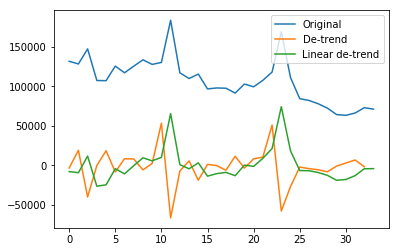

In [11]:
plt.plot(ts.values, label="Original")
plt.plot(difference(ts.values), label="De-trend")
plt.plot(linear(ts.values), label="Linear de-trend")
plt.legend()
plt.show()

**Observation** - Seemms like fitting a curve was able to remove the trend, and preserve the shape of the peaks.

In [12]:
result = adfuller(linear(ts.values))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.294868
p-value: 0.000006
Critical Values:
	5%: -2.998
	1%: -3.753
	10%: -2.639


**Observation** - After removing the trend, the curve is does not have a root according to the Augmented Dicky-Fuller Test.

## Next up - AR, MA and ARMA models
**Moving Average(MA) models** - specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term. Rather than using the past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.  

**Auto Regression(AR) models** - output variable depends linearly on the previous values of the time series.  

Checking if it's a MA or AR model

In [13]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

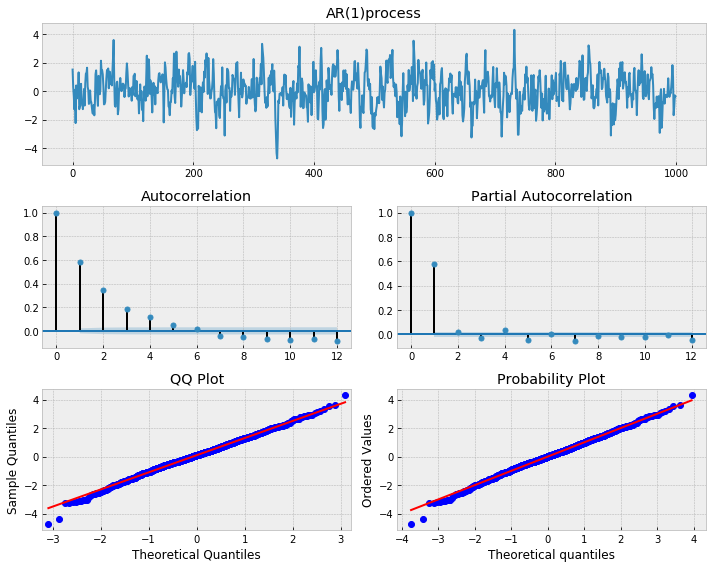

In [14]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

**Observation** - autocorrelation dies down, and lag = 1

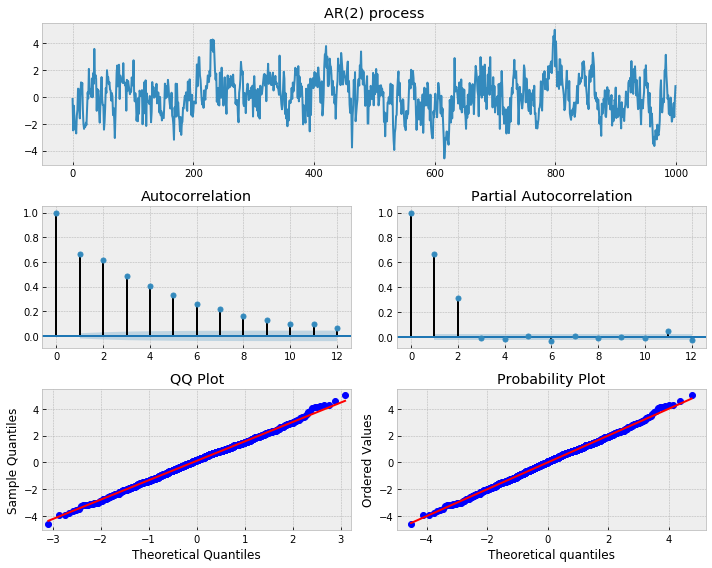

In [16]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

**Observation** -  Similarly autocorrelation is also wel;-behaved and lag= 2.

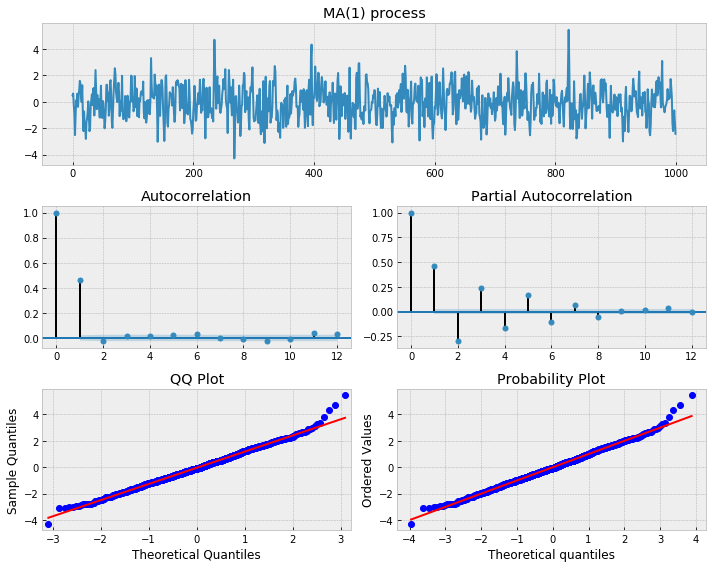

In [17]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

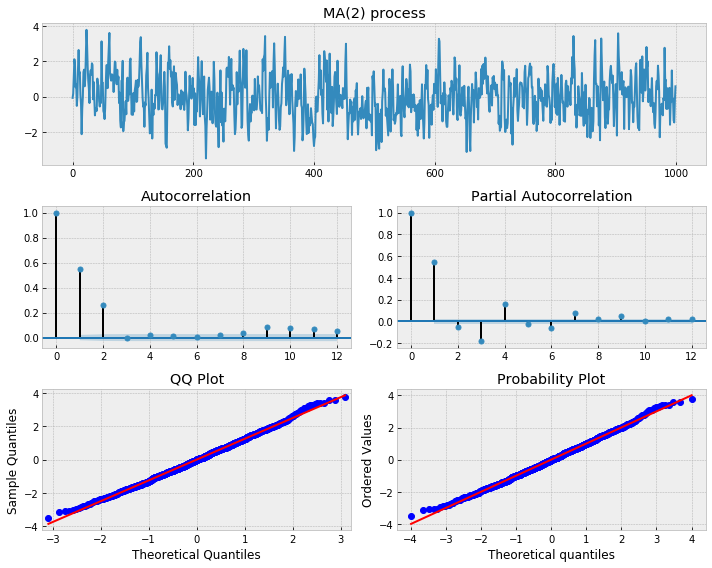

In [18]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

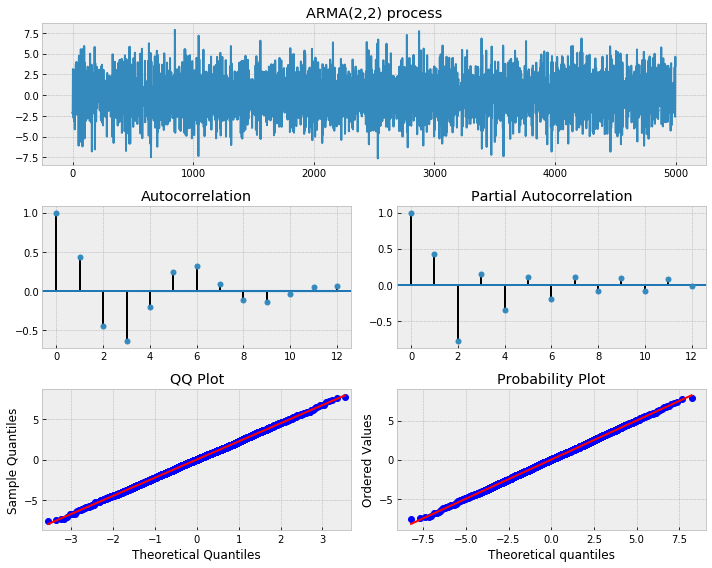

In [19]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

In [20]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


In [22]:

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 784.15690 | order: (1, 1)


**Conclusion** - We were able to find trend and seasonality in the dataset. Simulated MA, AR, and ARMA models, and fit ARMA model to the data to obtain the best fit. 